# ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 3

Исследование общей вариабельности и внутренней организации сердечного ритма
_______________________________________________________________________________________________________________________________

Цель работы: освоить статистические и геометрические методы анализа вариабельности сердечного ритма. 

Устанавливаем необходимые для выполнения лабораторной работы библиотеки

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib

Получаем данные с кардиоинтервалами, которые необходимо будет исследовать

In [94]:
df = pd.read_csv("3_f_1.csv", delimiter=',')
df

,arr
0,926
1,914
2,885
3,874
4,879
...,...
295,862
296,867
297,882
298,886


1. Расчет основных параметров вариабельности: среднее значение М, среднеквадратичное отклонение SDNN, коэффициент вариации CV.
Формулы:

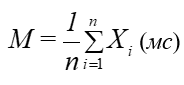
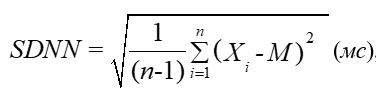
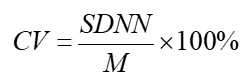

In [25]:
M = sum(df['arr']) / len(df['arr'])
s = 0
for i in df['arr']:
    s += (i - M) ** 2
SDNN = (1/ (len(df['arr'] - 1)) * s) ** 0.5
CV = (SDNN / M) * 100
print('M = ' + str(M) + ',\nSDNN = ' + str(SDNN) + ',\nCV = ' + str(CV) + '.')

M = 906.5066666666667,
SDNN = 60.713781704724084,
CV = 6.697554903592261.


Разделение всего массива кардиоинтервалов на различные массивы с шагом в 50 мс для дальнейшего построения гистограммы

In [57]:
commutes = [int(i) for i in df['arr']]
commutes = sorted(commutes)
commutes1 = []
commutes2 = []
tmp = commutes[0] + 50
for i in commutes:
    if i < tmp:
        commutes2.append(i)
    else:
        tmp += 50
        commutes1.append(commutes2)
        commutes2 = []
    if len(commutes2) == 0:
        commutes2.append(i)   
if len(commutes2) != 0:
    commutes1.append(commutes2)
for i in range(len(commutes1)):
    if len(commutes1[i]) == 1:
        commutes1[i].append(commutes1[i][0] + 1)

2.	По заданному массиву кардиоинтервалов построим гистограмму с шагом 50 мс (0.05 с) по следующему алгоритму:

a.	динамический ряд кардиоинтервалов разбивается на k интервалов длиной dx = 50 мс;

b.	вычисляется, сколько значений кардиоинтервалов xi попало в каждый из интервалов;

c.	частота попадания в какой-либо интервал получается делением числа попаданий на общее число кардиоинтервалов n;

d.	над каждым из интервалов разбиения строится прямоугольник, высота каждого прямоугольника равна частоте, деленной на Δx.

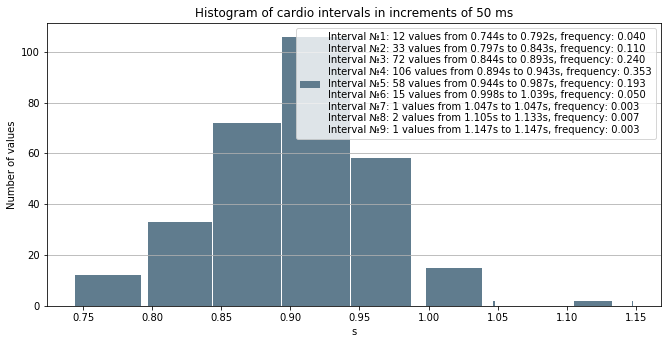

In [95]:
plt.subplots(figsize=(11, 5.2))
n, bins, bins_to, patches = [], [], [], []
for i in commutes1:
    commutes2 = pd.Series([float(j / 1000) for j in i])
    n1, bins1, patches1 = plt.hist(commutes2, bins=1, color='#607c8e')
    if len(i) == 2 and i[1]-i[0] == 1:
        n.append(1)
    else:
        n.append(n1[0])
    bins.append(bins1[0])
    bins_to.append(bins1[1])
    patches.append(patches1)
plt.title('Histogram of cardio intervals in increments of 50 ms')
plt.xlabel('s')
plt.ylabel('Number of values')
plt.grid(axis='y')
res = ""
for i in range(len(commutes1)):
    if (len(commutes1[i]) == 2) and (commutes1[i][1]-commutes1[i][0] == 1):
        res += "Interval №{}: {:.0f} values from {:.3f}s to {:.3f}s, frequency: {:.3f}\n".format(i+1, n[i], bins[i], bins[i], n[i]/len(df['arr']))
    else:
        res += "Interval №{}: {:.0f} values from {:.3f}s to {:.3f}s, frequency: {:.3f}\n".format(i+1, n[i], bins[i], bins_to[i], n[i]/len(df['arr']))
plt.legend([res.strip()])
plt.show()

3. Определение моды Mo, амплитуды моды AMo, которая соответствует максимальному значению вариабельности в интервале dx=50 мс.
4. Определение вариационного размаха MxDMn.
5. Расчет индекса напряжения регуляторных систем ИН (SI).

Формулы:
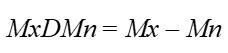
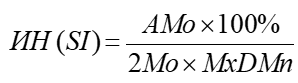

In [89]:
qty = [int(i) for i in df['arr']]
a_set = set(qty)
modaMax = 0
for i in a_set:
    moda = qty.count(i)
    if moda > modaMax:
        modNumb = i
        modaMax = moda
for i in range(len(bins) - 1):
    if modNumb >= bins[i] * 1000 and modNumb <= bins[i+1] * 1000:
        k = i
AMo = int(n[k])
MxDMn = commutes[len(commutes)-1] - commutes[0]
SI = (AMo * 100) / (2 * modNumb * MxDMn)
print('Mo = ' + str(modNumb) + ', AMo = ' + str(int(n[k])) + ';\nMxDMn = ' + str(MxDMn) + ';\nSI = ' + str(SI) + '.')

Mo = 897, AMo = 106;
MxDMn = 403;
SI = 0.014661499179785943.


Функция для получения массива коэффициентов корреляции, на основе которого будет построен график автокоррелограммы из задания 6.
Коэффециент корреляции получаем по формуле:
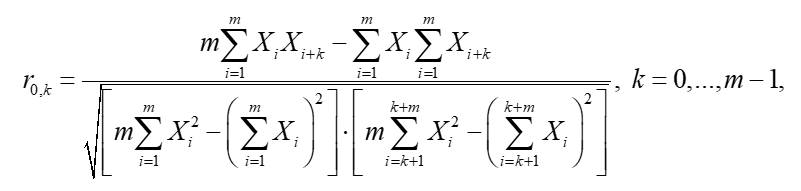

In [52]:
def coeff_r(m, qty):
    lst_rcoef = []
    for k in range(m-1):
        ik_sum, i_sum1, k_sum, sqi_sum1 = 0, 0, 0, 0
        i_sum2, sqi_sum2 = 0, 0
        for i in range(m+k):
            if i < m:
                ik_sum += qty[i] * qty[i+k]
                i_sum1 += qty[i]
                k_sum += qty[i+k]
                sqi_sum1 += qty[i] ** 2
            if i >= k+1:
                i_sum2 += qty[i]
                sqi_sum2 += qty[i] ** 2
        r = (m * ik_sum - i_sum1 * k_sum) / (((m * sqi_sum1 - i_sum1 ** 2) * (m * sqi_sum2 - i_sum2 ** 2)) ** 0.5)
        lst_rcoef.append(r)
    return lst_rcoef

6. По заданному массиву кардиоинтервалов построим график автокоррелограммы.

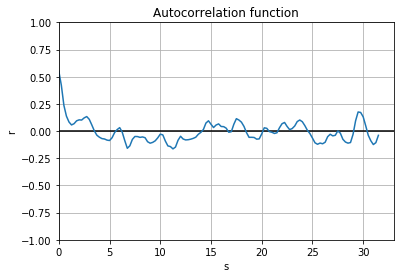

In [81]:
m = 128 #строим автокоррелограмму на основе 128 данных, как выполнено в примере, шаг также взят равным 250 мс
plt.figure()
plt.grid(True)
line = range(0, 36, 35)
plt.plot(line, [0, 0], color='black')
plt.plot([float(i * 0.25) for i in range(m - 1)], coeff_r(m, qty))
plt.xlim(0, m * 0.25 + 1)
plt.ylim(-1, 1)
plt.title("Autocorrelation function")
plt.xlabel('s')
plt.ylabel('r')
plt.show()

7. Расчет значения коэффициента корреляции после первого сдвига CC1 и числа сдвигов до первого нулевого значения коэффициента корреляции СС0.

In [84]:
r_arr = coeff_r(m, qty)
CC1 = r_arr[0]
if r_arr[0] > 0:
    k = 1
    while r_arr[k] > 0:
        k +=1
a =  (r_arr[k - 1] - r_arr[k]) / (0.25 * (k - 1) - 0.25 * k)
b = r_arr[k] - a * 0.25*k
CC0 = - (b / a)
print('CC0 = ' + str(CC0) + ",\nCC1 = " + str(CC1) + '.')

CC0 = 3.5128371052899885,
CC1 = 0.550795253676832.


Для построения корреляционной ритмограммы из задания 8, нужно для начала получить последовательности пар кардиоинтервалов по осям абсцисс и ординат, где для оси абсцисс окладывается величина 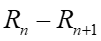 а по оси ординат - величина 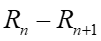

In [91]:
xR, yR = [], []
arrCor = [float(i / 1000) for i in df['arr']]
for i in range(1, len(arrCor) - 1):
    xR.append(arrCor[i-1] - arrCor[i])
    yR.append(arrCor[i] - arrCor[i+1])

xR1 = sorted(xR)
yR1 = sorted(yR)
mean = [xR1[int(len(xR1) / 2)], yR1[int(len(yR1) / 2)]]

8. Построение корреляционной ритмограммы (скаттерограммы) по заданному массиву кардиоинтервалов.

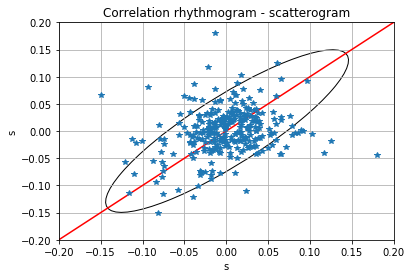

In [88]:
ell = matplotlib.patches.Ellipse(xy = mean, width = MxDMn / 1000, height = AMo / 1000, angle = 46, color='white', ec='black')
fig, ax = plt.subplots()
t = np.arange(-0.25, 0.25, 0.01)
plt.plot(t, t, color='red')
plt.grid(True)
plt.plot(xR, yR, '*')
ax.add_patch(ell)
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.title("Correlation rhythmogram - scatterogram")
plt.xlabel('s')
plt.ylabel('s')
plt.show()

Вывод:
В ходе выполнения лабораторной работы был выполнен анализ массива кардиоинтервалов. Был выполнен расчет основных параметров вариабельности кардиоинтервала; построена гистограмма с шагом 50 мс, которая отображала количество значений, которые попали в каждый из интервалов, выполняла расчет частоты попадания в любой из интервалов; на основе полученной гистограммы были расчитаны: мода и амплитуда моды, вариационный размах и значение индекса напряжения регуляторных систем; был построен график автокоррелограммы на основе массива коэффициентов корреляции, полученных от заданного массива кардинтервалов, и также на основе данного массива были получены: коэффициент корреляции после первого сдвига и число сдвигов до первого нулевого значения коэффициента корреляции; построена корреляционная ритмограмма, показывающая изменение сердечного цикла.